In [15]:
!pip install keras

In [16]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [85]:
train_data.shape

(404, 13)

In [18]:
test_data.shape

(102, 13)

In [19]:
train_data[0]

array([   1.23247,    0.     ,    8.14   ,    0.     ,    0.538  ,
          6.142  ,   91.7    ,    3.9769 ,    4.     ,  307.     ,
         21.     ,  396.9    ,   18.72   ])

Feature-wise normalization

In [20]:
mean = train_data.mean(axis=0)
train_data -=mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /- std

array([[-1.55369355,  0.48361547, -1.0283258 , ..., -0.78447637,
         3.48459553, -2.25092074],
       [ 0.39242675,  0.48361547,  0.16087773, ...,  0.30759583,
        -0.42733126, -0.47880119],
       [ 0.39982927,  0.48361547,  0.86940196, ..., -0.78447637,
        -0.44807713,  0.41415936],
       ..., 
       [ 0.20709507,  0.48361547, -1.24588095, ...,  1.71818909,
        -0.37051949,  1.49344089],
       [ 0.36698601,  0.48361547,  0.72093526, ...,  0.48960787,
        -0.39275481,  0.41829982],
       [ 0.0889679 ,  0.48361547, -1.24588095, ...,  1.71818909,
         1.21946544,  0.40449827]])

In [78]:
from keras import layers
from keras import models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))

    # no activation, so linear layer
    model.add(layers.Dense(1))
    
    
    # mae = mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

Implement k-folds validation

In [70]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_targets  = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
            validation_data=(val_data, val_targets),
            epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)
    all_mae_histories.append(history.history['val_mean_absolute_error'])

('processing fold #', 0)
101/101 [==============================] - 0s 63us/step
('processing fold #', 1)
101/101 [==============================] - 0s 62us/step
('processing fold #', 2)
101/101 [==============================] - 0s 62us/step
('processing fold #', 3)
101/101 [==============================] - 0s 79us/step


In [71]:
np.mean(all_scores)

2.6600844638772529

In [72]:
all_scores

[2.2747360621348465, 2.8804110748933094, 2.56272026571897, 2.9224704527618863]

In [73]:
average_mae_history = np.mean(np.array(all_mae_histories), axis=0)

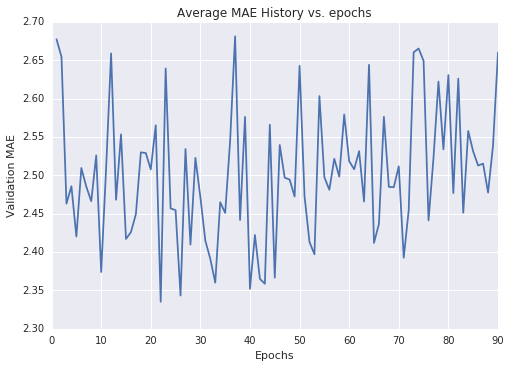

In [74]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1-10), average_mae_history[10:])
plt.title('Average MAE History vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [75]:
def smooth_curve (points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [76]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

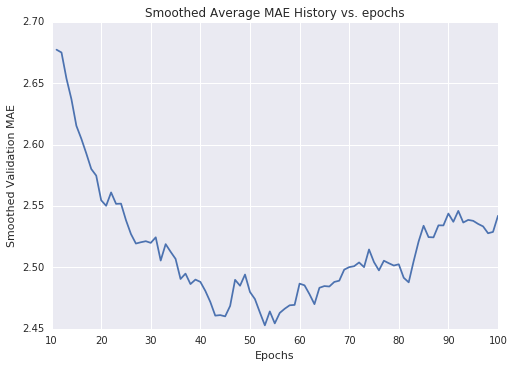

In [77]:


plt.plot(range(1+10, len(smooth_mae_history)+1+10), smooth_mae_history)
plt.title('Smoothed Average MAE History vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Smoothed Validation MAE')

plt.show()

In [81]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 3ms/step


In [82]:
print(test_mse_score)

769201.544118


In [84]:
print(test_mae_score)

825.168936935
